# 多項近似のバイアスとバリアンスを計算する。

- h(x) の代わりに観測値を使ってバイアス、バリアンスを計算する。
- xについては平均をとる
- 多項式の次元を `p = 1, 3, 6, 10`  の次数ごとに計算をしてもっとも良い次数を求める。
- このときパラメータは線形回帰で求める。

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yohei.moriya/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yoh

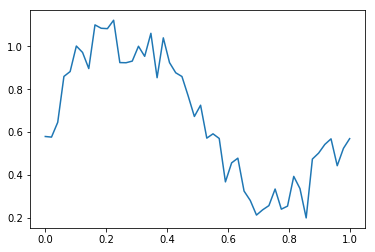

In [2]:
def get_data(vec_x) -> np.ndarray:
    '''
    データセットを取得します。
    '''
    error = np.random.random(vec_x.size) * 0.3
    vec_f = 0.5 + 0.4 * np.sin(2*np.pi*vec_x) + error
    return vec_f

# def get_dataset():
#     vec_x, vec_y = get_data()
#     nd_origin = np.vstack((vec_x, vec_y))
#     df_origin = pd.DataFrame(nd_origin).T
#     df_train = df_origin.sample(frac=0.7, random_state=1).sort_index()
#     df_test = df_origin.drop(df_train.index)
#     train_x, train_y = df_train[0],  df_train[1]
#     test_x, test_y = df_test[0], df_test[1]
#     return train_x, train_y, test_x, test_y

x_size = 50
vec_x = np.linspace(0, 1, x_size)
vec_f = get_data(vec_x)
plt.plot(vec_x, vec_f)
plt.show()

# train_x, train_y, test_x, test_y = get_dataset()
# plt.plot(train_x, train_y)
# plt.plot(test_x, test_y)
# plt.show()

In [3]:
class Aggregator():
    '''
    情報を貯蓄して解析する集積器です。
    内部でキーに対応したリストを保持しています。
    '''
    def __init__(self):
        self.values = {}

    def savings(self, key, value):
        '''
        値をキーに対応したリストに保存します。
        '''
        if key not in self.values:
            self.values[key] = []
        self.values[key].append(value)
        pass
    
    def total(self):
        '''
        貯蓄した値を集計します。
        '''
        dict_result = {}
        for key in self.values:
            info = {}
            info['mean'] = np.array(self.values[key]).mean()
            #info['var'] = np.array(self.values[key]).var()
            dict_result[key] = info
        return pd.DataFrame.from_dict(dict_result).T
    
    def destory(self):
        '''
        貯蔵した値を破棄します。
        '''
        self.values = {}

memory = Aggregator()
memory.savings('key1', 1)
memory.savings('key1', 2)
memory.savings('key2', 3)
print(memory.values)

{'key1': [1, 2], 'key2': [3]}


In [4]:
class DataSets:
    '''
    データのコレクションです。
    :param vec_x  xが取る値
    :param nd_y  yが取る値のN個の集まり (N × x.size)
    :param nd_g　yによって与えられた予測の値 (N × x.size)
    '''

    def __init__(self, vec_x):
        self.x = vec_x
        self.nd_y = np.empty((0, vec_x.size))
        self.nd_h = np.empty((0, vec_x.size))
        
    def add(self, vec_y):
        '''
        予測値を追加します。
        '''
        self.nd_y = np.append(self.nd_y, vec_y.reshape(1, vec_y.size), axis=0)
        #self.nd_y.extend(vec_y)
    
    def get_size(self):
        '''
        データの個数を取得します。
        '''
        return self.nd_y.shape[0]
    
    def save(self, vec_h):
        '''
        　予測した値を保存します。
        '''
        self.nd_h = np.append(self.nd_h, vec_h.reshape(1, vec_h.size), axis=0)

    def destory(self):
        '''
        予測した値を破棄します。
        '''
        self.nd_h = np.empty((0, self.x.size))

x_size = 50
vec_x = np.linspace(0, 1, x_size)
data = DataSets(vec_x)
print(data.nd_y.shape)
for i in range(20):
    data.add(get_data(vec_x))
print(data.nd_y.shape)
print(data.get_size())

(0, 50)
(20, 50)
20


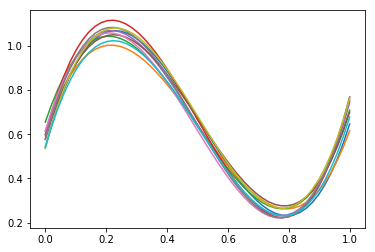

(10, 50)

In [5]:
def fit(train_x, train_y, p):
    '''
    yについて、xを用いて次数pの多項式近似をします。
    '''
    vec_w = np.polyfit(train_x, train_y, p)
    vec_h = np.poly1d(vec_w)(train_x)
    return vec_h


x_size = 50
vec_x = np.linspace(0, 1, x_size)
data = DataSets(vec_x)
for i in range(10):
    data.add(get_data(vec_x))

for y in data.nd_y:
    vec_h = fit(data.x, y, 3)
    data.save(vec_h)
    plt.plot(vec_x, vec_h)

# plt.plot(vec_x, test_y)
plt.show()
data.nd_y.shape

In [29]:
def cal_bias(vec_h, vec_t):
    '''
    バイアスを計算します
    '''
    mean_h = vec_h.mean(axis=0)
    item =  mean_h - vec_t.mean(axis=0)
    result = (item ** 2)
    print(f"bias:{result.shape}, vec_h: {vec_h.shape}, vec_t: {vec_t.shape}")
    return result

def cal_variance(vec_h):
    '''
    バリアンスを計算します
    '''
    mean_h = vec_h.mean(axis=0)
    item = vec_h - mean_h
    result = np.mean(item ** 2)
    print(f"variance:{result}, vec_h: {vec_h.shape}")
    return result


In [32]:
def run(data, p, memory):
    '''
    渡された次数で、バイアスとバリアンスを計算してメモリーに保存します。
    '''
    for y in data.nd_y:
        vec_h = fit(data.x, y, p)
        data.save(vec_h)
    vec_h = data.nd_h
    vec_y = data.nd_y
#     print(f"vec_h : {vec_h.shape}")
#     print(f"vec_y : {vec_y.shape}")
#     for h, y in zip(vec_h, vec_y):
#         memory.savings(str(p)+'#bias', cal_bias(h, y))
#         memory.savings(str(p)+'#variance', cal_variance(h))
    memory.savings(str(p)+'#bias', cal_bias(vec_h, vec_y))
    memory.savings(str(p)+'#variance', cal_variance(vec_h))

    return memory

# test
x_size = 50
vec_x = np.linspace(0, 1, x_size)
data = DataSets(vec_x)
for i in range(20):
    data.add(get_data(vec_x))

memory = Aggregator()
memory = run(data, 3, memory)
memory.total()

bias:(50,), vec_h: (20, 50), vec_t: (20, 50)
variance:0.0005725282012183683, vec_h: (20, 50)


,mean
3#bias,0.001214
3#variance,0.000573


In [33]:
def main():
    memory = Aggregator()
    list_p = [1, 3, 6, 10]
    
    x_size = 50
    vec_x = np.linspace(0, 1, x_size)
    data = DataSets(vec_x)
    for i in range(20):
        data.add(get_data(vec_x))
    for p in list_p:
        memory = run(data, p, memory)
        data.destory()
    display(memory.total())
    
main()

bias:(50,), vec_h: (20, 50), vec_t: (20, 50)
variance:0.00021983061689606693, vec_h: (20, 50)
bias:(50,), vec_h: (20, 50), vec_t: (20, 50)
variance:0.0005025451528679752, vec_h: (20, 50)
bias:(50,), vec_h: (20, 50), vec_t: (20, 50)
variance:0.0007777412801096094, vec_h: (20, 50)
bias:(50,), vec_h: (20, 50), vec_t: (20, 50)
variance:0.0013261938905826, vec_h: (20, 50)


,mean
1#bias,0.034153
1#variance,0.000220
3#bias,0.001451
3#variance,0.000503
6#bias,0.000497
6#variance,0.000778
10#bias,0.000419
10#variance,0.001326
